In [39]:
%pylab nbagg
from tvb.simulator.lab import *
LOG= get_logger('demo')
from tvb.simulator.plot.tools import *

# Exploring information flow between memory and oculomotor systems

We want to look into possible pathways and their functional significance. We will start off by running a V1 stimulations to check our parameters. Once you are happy with your activation times and parameters. We will stimulation one of the hippocampal nodes and check their activation times if they ever activate. 

## Defining the stimulus 

We'll start by choosing a specific node to stimulate, in this case V1, and defining the weighting of the stimulus coming into that node. Below we'll define the temporal profile with the default Gaussian equation. 

In [4]:
v1_node = 68
#spatial pattern
weighting = numpy.zeros((154))
weighting [[v1_node]] = 0.03

#temporal profile
eqn_t = equations.PulseTrain()
eqn_t.parameters['onset'] = 10000
eqn_t.parameters['T'] = 1000.0
eqn_t.parameters['tau'] = 50.0

We will be using a connectivity matrix that is not the default matrix and so we will need to load in this matrix. Make sure after loading it in you should name the files appropriately, zip them and then place the package in the connectivity file in tvb's data. 

In [5]:
new_conn= connectivity.Connectivity.from_file("newconn.zip")
new_conn.configure()
new_conn.weights= (np.loadtxt('/home/htian/Data/avg9/weights.txt'))
new_conn.tract_lengths= np.loadtxt('/home/htian/Data/avg9/tract_lengths.txt')

Now, combine the spatial pattern with the temporal profile into one object. We must first configure the stimulus which happens automatically in the simulator. 

In [6]:
stimulus = patterns.StimuliRegion( temporal = eqn_t, 
                                  connectivity = new_conn, 
                                  weight = weighting)

In [7]:
stimulus.configure_space()
stimulus.configure_time(numpy.arange(0.,12000, 2**-4))

## Simulate

We must define the parameters for our simulation. Here we are using parameters that we've come up with based off of the Spiegler model and previous trials. Adjust these values to what best fits your data.

In [8]:
mod= models.Generic2dOscillator(d = (1/1000.) * 76.74,
                                tau =1., f= 1.,e= 0., g= -0.1, 
                            alpha =1., gamma= 1., c= 0., b= -12.3083, beta =0., a =0.)
integrators = integrators.HeunStochastic(dt = 0.1, noise=noise.Additive(nsig=5e-15)) 
coupling = coupling.Linear(a=0.01)
monitors= monitors.TemporalAverage(period = 1.0)
new_conn.speed= 8.

Create and run the simulation 

In [9]:
sim = simulator.Simulator(
        model = mod,
        connectivity = new_conn,
        coupling = coupling,
        integrator = integrators,
        monitors = monitors,
        stimulus = stimulus, 
        simulation_length = 12000,
        ).configure()

(tavg_time, tavg_data), = sim.run()

## Visualize

Since the stimulated node's amplitude is much greater than the amplitudes of the other nodes. To be able to see the data in an appropriate scope we will exclude the stimulated node from certain calculations. Here we are inlcuding all the data except the data of the stimulated node into an array. 

In [10]:
lst_nodes = [i for i in range(154) if i != v1_node]
nostimnode=tavg_data[:, 0, lst_nodes, 0]

In the graph, the black lines will represent all nodes except the stimulated node, red is for the stimulated node, and green is for certain nodes that we want to investigate.


In [11]:
datas_raw= (nostimnode)
v1_raw= (tavg_data[:, 0, v1_node, 0])
follow_raw=( tavg_data[:, 0, 36, 0],tavg_data[:, 0, 45, 0],tavg_data[:, 0, 46, 0],tavg_data[:, 0, 47, 0],
             tavg_data[:, 0, 69, 0],tavg_data[:, 0, 70, 0],tavg_data[:, 0, 72, 0])
#follow nodes are in the order FEF, MSTd, MSTl, MT, V1, V2, V3, V4 

datas= np.squeeze(datas_raw)
v1= np.squeeze(v1_raw).T
follow = np.squeeze(follow_raw).T

<IPython.core.display.Javascript object>


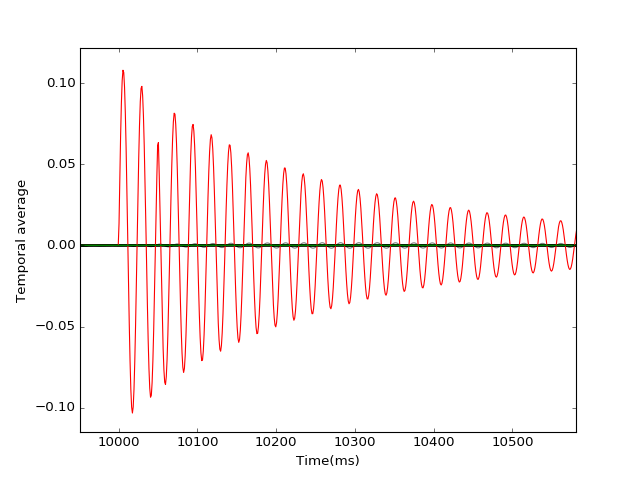

In [40]:
#time vs temporal average graph
figure()
plot(tavg_time, datas,'k', alpha = 0.5)
plot(tavg_time, v1, 'r', alpha = 1)
plot(tavg_time, follow, 'g', alpha =0.5)
ylabel("Temporal average")
xlabel ("Time(ms)")
plt.grid('off')

## Finding thresholds

We will need to define thresholds of each invidual node. Here we are using the data 200 ms before stimlation. After finding the maximum amplitude of each node in that time period, we will make an array in the same shape as the shape of the data we are comparing it to. Next, look for when the data is greater than the maximum then when it is less than the maximum. Finally, we add them together in a single array to see when it passes threshold.

In [13]:
time_notrans = tavg_time[range(9800,12000)]
data_notrans_mean= tavg_data.squeeze().T[:,range(9800, 10000)]
data_notrans= tavg_data.squeeze().T[:,range(9800, 12000)]

data_notrans_posthr= []
data_notrans_negthr= []
data_notrans_thr= []

for node in range(len(data_notrans_mean)):
    data_notrans_posthr.append(np.array(data_notrans[node]>(data_notrans_mean[node].max())))
    data_notrans_negthr.append(np.array(data_notrans[node]<(data_notrans_mean[node].min())))
    
    data_notrans_thr.append(np.array(data_notrans_posthr[node] + data_notrans_negthr[node]))

## Finding activation times

Here we will be finding the activation times using the positive and negative thresholds. We have already compared the data with the thresholds to see what times it will surpass them. We will first find them for all nodes followed by calculating them for the specified nodes.

In [14]:
activation_time=np.array(np.zeros(len(data_notrans_thr)))
for node in range(len(data_notrans_thr)):
    for time in range(9800,12000):
        if np.array(data_notrans_thr[node][time -9800]) == True:
            activation_time[node]=time
            break
        else:
            activation_time[node]= nan
#activation_time

Compare the times to see if they match the results from the empircal data, if not change the parameters and try again.

In [15]:
s = [36,45,46,47,68,69,70,72]
activation_time_spec=np.array(np.zeros(len(s)))
i= 0

for node in s: 
    for time in range(9800,12000):
        if np.array(data_notrans_thr[node][time -9800]) == True:
            activation_time_spec[i]=time
            break
        else:
            activation_time_spec[i]= nan
    i += 1
activation_time_spec

array([ 10389.,  10031.,  10031.,  10003.,  10000.,  10002.,  10001.,
        10003.])

## Loading in region labels

Load in region labels and place them in a dataframe for easy manipulation later. 

In [16]:
import pandas as pd
pd.set_option('display.max_rows',200)
df_tavg = pd.DataFrame(np.squeeze(tavg_data),index=tavg_time)

labs= pd.read_csv('/home/htian/Data/kelly_matrix/labelnames.txt',sep='\t')['acronym'].values

lh_labs = [l + '_L' for l in labs]
rh_labs = [l + '_R' for l in labs]
region_labels_lr = np.concatenate([lh_labs, rh_labs])

df_tavg_labs = df_tavg.copy()
df_tavg_labs.columns= region_labels_lr


## Bar Graphs

We'll be graphing a bunch of bar graphs for visualization purposes.

#### activation times of all nodes

To display the activation times we will want to start displaying the time of the stimulation as 0. To do this we will need to loop through the activation times and subtract 10000 from each value. If the value is already less than 10000 we will replace it with nan since it does not activate.

In [ ]:
activation_times=np.zeros(len(activation_time))

for i in range(len(activation_time)):
    if activation_time[i] == 0 or activation_time[i] < 10000:
        activation_times[i]= nan
    else:
        activation_times[i]= activation_time[i] - 10000

Since our data doesn't include the stimulated node, we will need to remove that label from our labels. 

In [ ]:
lst_nodes = [i for i in range(154) if i != v1_node]
labels_nostim=region_labels_lr[lst_nodes]

Now, just load the labels and activation times into a dataframe. Then, sort the activation times in ascending order. Finally, plot the ordered activation times.

In [ ]:
df_activation= pd.DataFrame(activation_times, region_labels_lr) 

df_activation_sort = df_activation.sort(columns =0)

In [ ]:
ax = df_activation_sort.plot(kind='barh', title="distances", figsize=(17,17), legend=False)
y_pos = np.arange(len(df_activation_sort))
width= 0.35
rects = ax.barh(y_pos, df_activation_sort, width)

ax.set_ylabel('node acronyms')
ax.set_xlabel('time activation(ms)')
ax.invert_yaxis()
ax.set_title('Node Activation Times')

#### activation times of specific nodes

Now repeat the same process for your specified nodes

In [ ]:
activation_times_spec=np.zeros(len(activation_time_spec))

for i in range(len(activation_time_spec)):
    if activation_time_spec[i] == 0 or activation_time_spec[i] < 10000:
        activation_times_spec[i]= 0
    else:
        activation_times_spec[i]= activation_time_spec[i] - 10000

Here, you will need to manually include your label names in the same order as before or feel free to write a loop to include the labels that you want. 

In [ ]:
lab_spec= np.array(['FEF_L', 'MST(45)', 'MST(46)', 'MT_L', 'V1_L', 'V2_L', 'V3_L', 'V4_L'])

In [ ]:
df_activation_spec= pd.DataFrame(activation_times_spec, lab_spec) 

df_activation_spec_sort = df_activation_spec.sort(columns= 0)

In [ ]:
ax = df_activation_spec_sort.plot(kind='barh', title="distances", figsize=(6,3), legend=False)
y_pos = np.arange(len(df_activation_spec_sort))
width= 0.05
rects = ax.barh(y_pos, df_activation_spec_sort, width)

ax.set_ylabel('node acronyms')
ax.set_xlabel('time activation(ms)')
ax.invert_yaxis()
ax.set_title('Node Activation Times')

#### distances

We'll be making a bar graph to display the distances in order of closest to farthest nodes from our stimulated node (V1 for this case).

In [ ]:
i =v1_node
distances= np.array(np.zeros(len(new_conn.tract_lengths)))

for j in range(len(new_conn.tract_lengths)):
    distances[j]= new_conn.tract_lengths[i, j]

Here we will need to slice the distances array at 77 because we only care about the distances of the nodes in the left hemisphere. Load them into a dataframe then sort. Then, plot. 

In [ ]:
df_distances= pd.DataFrame([labs, distances[:77]]).T

df_distances_labs= df_distances.sort(columns= 1, ascending= True)

In [ ]:
ax = df_distances_labs.plot(kind='barh', title="distances", figsize=(10,10), legend=False)

y_pos = np.arange(len(distances[:77]))
width= 0.35
rects = ax.barh(y_pos,df_distances_labs[1], width)
ax.set_ylabel('node acronyms')
ax.set_xlabel('Distances')
ax.set_title('Distance from node "V1"')
ax.invert_yaxis()

ax.set_yticks(range(len(labs)))
ytickNames = ax.set_yticklabels(df_distances_labs[0])

## Finding amplitudes of each node

To find the amplitudes we will need to loop through the data (excluding the stimulated node) and make an array of each node's max

In [ ]:
#no stim node in this data set
max_amp= []
for node in range(len(nostimnode.T)):
    max_amp.append(max(abs(nostimnode.T[node, :])))

In [ ]:
df_max_amp= pd.DataFrame(max_amp, labels_nostim) 

df_max_amp_sort= df_max_amp.sort(columns=0)

In [ ]:
ax = df_max_amp_sort.plot(kind='barh', title="amplitudes", figsize=(10,10), legend=False)
y_pos = np.arange(len(df_max_amp_sort))
width= 0.35
rects = ax.barh(y_pos, df_max_amp_sort, width)

ax.set_ylabel('node acronyms')
ax.set_xlabel('amplitude')
ax.invert_yaxis()
ax.set_title('Amplitudes')

## Heat Map

As another way to visualize the dissipation of the stimulus is to use a heatmap. It is important to adjust vmin and vmax accordingly.  

In [ ]:
import seaborn as sns

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(df_tavg_labs.ix[9800:12000].T, ax=ax, vmin=-0.001, vmax=0.001, xticklabels='')
ax.imshow(df_tavg.ix[9800:12000].T.values,vmin=-0.001, vmax=0.001, aspect='auto',cmap='coolwarm',
          interpolation='none')
ax.set_yticklabels
ax.grid('off')
for label in ax.get_yticklabels(): label.set_rotation(0)

## Covariance matrix

We will need to calculate the covariance values 200ms before the stimulationand plot them on a matrix

In [ ]:
dat_notrans_prestim= np.squeeze(nostimnode.T)[:,range(9800, 10000)]
dat_notrans_cov = np.cov(dat_notrans_prestim)

fig, ax= plt.subplots(figsize= (9,9))
fig.canvas.draw()
ax.set_xticks(range(len(labels_nostim)))
ax.set_yticks(range(len(labels_nostim)))
ax.set_xticklabels(labels_nostim,rotation=90,fontsize=8)
ax.set_yticklabels(labels_nostim, fontsize=8)
plt.imshow(dat_notrans_cov, cmap= 'jet')
plt.grid('off')
plt.colorbar()

#### Eigenvector matrix

Calculate the Eigen vector matrix from covariance matrix and plot

In [ ]:
from scipy.linalg import eig

dat_notrans_cov_evals, dat_notrans_cov_evecs = np.linalg.eig(dat_notrans_cov)

fig, ax =plt.subplots(figsize= (9,9))
fig.canvas.draw()
ax.set_xticks(range(len(labels_nostim)))
ax.set_yticks(range(len(labels_nostim)))
ax.set_xticklabels(labels_nostim,rotation=90,fontsize=8)
ax.set_yticklabels(labels_nostim, fontsize= 8)

dat_notrans_cov_evecs_154 = np.zeros([154,154])
dat_notrans_cov_evecs_154[:153,:153] = dat_notrans_cov_evecs
plt.imshow(dat_notrans_cov_evecs_154, cmap= 'jet')
plt.grid('off')
plt.colorbar()

---


Later, our data will require a null entry so we will create a version of our eigenvector matrix that has 155 nodes as the last one will be for the null entry. 

In [ ]:
dat_notrans_cov_evecs_155 = np.zeros([155,155])
dat_notrans_cov_evecs_155[:153,:153] = dat_notrans_cov_evecs

## Time Slice on Brain Surface

To follow the dissipation visually, we will be plotting the data on a brain surface.

In [ ]:
from tvb.datatypes.cortex import Cortex
from tvb.datatypes.region_mapping import RegionMapping
from tvb.datatypes.projections import ProjectionMatrix
import pandas as pd
from matplotlib.tri import Triangulation
from numpy import pi, cos, sin
from matplotlib import cm

In [ ]:
def plot_surface_mpl(vtx,tri,data=None,rm=None,reorient=None,view='superior',
                     shaded=False,ax=None,figsize=(6,4), title=None,
                     lthr=None,uthr=None, nz_thr = 1E-20,
                     shade_kwargs = {'edgecolors': 'k', 'linewidth': 0.1,
                                     'alpha': None, 'cmap': 'coolwarm',
                                     'vmin': None, 'vmax': None}):

    # in the namespace inadvertently. 
    vtx,tri = vtx.copy(),tri.copy()
    if data is not None: data = data.copy()

    # 1. Set the viewing angle 
  
    if reorient == 'tvb':
        # The tvb default brain has coordinates in the order 
        # yxz for some reason. So first change that:   
        vtx = np.array([vtx[:,1],vtx[:,0],vtx[:,2]]).T.copy()
        # Also need to reflect in the x axis
        vtx[:,0]*=-1

    # (reorient == 'fs' is same as reorient=None; so not strictly needed
    #  but is included for clarity)

    # ...get rotations for standard view options
    
    if   view == 'lh_lat'    : rots =  [(0,-90),(1,90)  ]
    elif view == 'lh_med'    : rots =  [(0,-90),(1,-90) ] 
    elif view == 'rh_lat'    : rots =  [(0,-90),(1,-90) ]
    elif view == 'rh_med'    : rots =  [(0,-90),(1,90)  ]
    elif view == 'superior'  : rots =   None
    elif view == 'inferior'  : rots =   (1,180)
    elif view == 'anterior'  : rots =   (0,-90)
    elif view == 'posterior' : rots =  [(0, -90),(1,180)]
    elif (type(view) == tuple) or (type(view) == list): rots = view 

    # (rh_lat is the default 'view' argument because no rotations are 
    #  for that one; so if no view is specified when the function is called, 
    #  the 'rh_lat' option is chose here and the surface is shown 'as is'                          
                            
    # ...apply rotations                          
    if rots is None: rotmat = np.eye(3)
    else:            rotmat = get_combined_rotation_matrix(rots)
    vtx = np.dot(vtx,rotmat)

    # 2. Sort out the data
                                    
    # ...if no data is given, plot a vector of 1s. 
    #    if using region data, create corresponding surface vector 
    if data is None: 
        data = np.ones(vtx.shape[0]) 
    elif data.shape[0] != vtx.shape[0]: 
        data = np.array([data[r] for r in rm])
    
    # ...apply thresholds
    if uthr: data *= (data < uthr)
    if lthr: data *= (data > lthr)
    data *= (np.abs(data) > nz_thr)

    # 3. Create the surface triangulation object 
    x,y,z = vtx.T
    tx,ty,tz = vtx[tri].mean(axis=1).T
    tr = Triangulation(x,y,tri[np.argsort(tz)])
                
    # 4. Make the figure 
    if ax is None: fig, ax = plt.subplots(figsize=figsize)  
  
    #if shade = 'gouraud': shade_opts['shade'] = 
    tc = ax.tripcolor(tr, np.squeeze(data), **shade_kwargs)
                        
    ax.set_aspect('equal')
    ax.axis('off')
    
    if title is not None: ax.set_title(title)


In [ ]:
def plot_surface_mpl_mv(vtx=None,tri=None,data=None,rm=None,hemi=None,   # Option 1
                        vtx_lh=None,tri_lh=None,data_lh=None,rm_lh=None, # Option 2
                        vtx_rh=None,tri_rh=None,data_rh=None,rm_rh=None,
                        title=None,**kwargs):
 
    if vtx is not None:                                    # Option 1
        tri_hemi = hemi[tri].any(axis=1)
        tri_lh,tri_rh = tri[tri_hemi==0],tri[tri_hemi==1]
    elif vtx_lh is not None:                               # Option 2
        vtx = np.vstack([vtx_lh,vtx_rh])
        tri = np.vstack([tri_lh,tri_rh+tri_lh.max()+1])

    if data_lh is not None:                                # Option 2
        data = np.hstack([data_lh,data_rh])
    
    if rm_lh is not None:                                  # Option 2 
        rm = np.hstack([rm_lh,rm_rh + rm_lh.max() + 1])
    
 
    # 2. Now do the plots for each view

    # (Note: for the single hemispheres we only need lh/rh arrays for the 
    #  faces (tri); the full vertices, region mapping, and data arrays
    #  can be given as arguments, they just won't be shown if they aren't 
    #  connected by the faces in tri )
  
    # LH lateral
    plot_surface_mpl(vtx,tri_lh,data=data,rm=rm,view='lh_lat',
                   ax=subplot(2,3,1),**kwargs)
    
    # LH medial
    plot_surface_mpl(vtx,tri_lh, data=data,rm=rm,view='lh_med',
                   ax=subplot(2,3,4),**kwargs)
    
    # RH lateral
    plot_surface_mpl(vtx,tri_rh, data=data,rm=rm,view='rh_lat',
                   ax=subplot(2,3,3),**kwargs)
    
    # RH medial
    plot_surface_mpl(vtx,tri_rh, data=data,rm=rm,view='rh_med',
                   ax=subplot(2,3,6),**kwargs)
    
    # Both superior
    plot_surface_mpl(vtx,tri, data=data,rm=rm,view='superior',
                   ax=subplot(1,3,2),title=title,**kwargs)
    
    plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0,
                      top=1.0, wspace=0, hspace=0) 
    

In [ ]:
def get_combined_rotation_matrix(rotations):
    rotmat = np.eye(3)
    
    if type(rotations) is tuple: rotations = [rotations] 
    for r in rotations:
        newrot = get_rotation_matrix(r[0],r[1])
        rotmat = np.dot(rotmat,newrot)
    return rotmat

In [ ]:
def get_rotation_matrix(rotation_axis, deg):
    # (note make deg minus to change from anticlockwise to clockwise rotation)
    th = -deg * (pi/180) # convert degrees to radians
    
    if rotation_axis == 0:
        return np.array( [[    1,         0,         0    ],
                          [    0,      cos(th),   -sin(th)],
                          [    0,      sin(th),    cos(th)]])
    elif rotation_axis ==1:
        return np.array( [[   cos(th),    0,        sin(th)],
                          [    0,         1,          0    ],
                          [  -sin(th),    0,        cos(th)]])
    elif rotation_axis ==2:
        return np.array([[   cos(th),  -sin(th),     0    ],
                         [    sin(th),   cos(th),     0   ],
                         [     0,         0,          1   ]])

We willl now need to load in the region mapping files to help us create the plotting surface. Here, we have appended the path where our files are located. Our region mapping file works when manually loaded in so that is what we will do for our file but feel free to attach the zip file name instead. 

In [ ]:
ctx_file ='/home/htian/Data/newzip.zip'
rm= np.loadtxt('/home/htian/Data/region_mapping.txt').astype(int)
hemi= np.loadtxt('/home/htian/Data/fv91_srfData_20170215/hemispheres.txt').astype(int)

In [ ]:
ctx = cortex.Cortex.from_file(source_file = ctx_file)
vtx,tri = ctx.vertices,ctx.triangles
df_tavg = pd.DataFrame(np.squeeze(tavg_data),index=tavg_time)

We're going to normalize all values at their respective time. We will set the stimulated node to 0 because we only care about the amplitudes of all other nodes and we don't want it to be taken as the maximum.

In [ ]:
notstim= np.squeeze(tavg_data).copy()
notstim[:, 68]= 0
m = np.array([(np.abs(notstim[i])).max() for i in range(len(notstim))])
for i in range(len(notstim)):
    for j in range(len(notstim[1])):
        print i,
        notstim[i,j] /= m[i]
        
df_notstim = pd.DataFrame(notstim,index=tavg_time)

# Make the plot

We will be saving the figures then displaying them since these are a little big and have difficulties loading them on the spot. Expect at least a few minutes for the figures to load. Change the ts times to display the time frames you want to look at. 

In [ ]:
cd '/tmp'

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=10)
cmap = cm.Reds
cmap.set_under(color='w')

kws = {'edgecolors': 'k', 'vmin': 0, 'cmap': cmap, 
       'vmax': 1, 'alpha': None, 'linewidth': 0.01}

ts=[10000.5, 10035.5, 10070.5, 10105.5, 10140.5, 10175.5, 10210.5, 10245.5, 10280.5, 10315.5]

for t_it,t in enumerate(ts):

    data = np.append(df_notstim.ix[t].abs().values, nan)
    
    plot_surface_mpl_mv(vtx=vtx,tri=tri,rm=rm,data=data, figsize=(10,10),
                    hemi=hemi ,shade_kwargs=kws) 
    
    f = '/tmp/braintmp_v1_t%1.1fms.png' %t
    plt.savefig(f,bbox_inches='tight')
    plt.close()

In [ ]:
fig, ax = plt.subplots(nrows=10, figsize= (12,40))

for t_it,t in enumerate(ts):
    f =  '/tmp/braintmp_v1_t%1.1fms.png' %t
    ax[t_it].imshow(plt.imread(f))
    ax[t_it].axis('off')
    ax[t_it].set_title('t=%1.1fms' %t,fontsize=9)

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=10)
cmap = cm.Reds
cmap.set_under(color='w')

kws = {'edgecolors': 'k', 'vmin': 0, 'cmap': cmap, 
       'vmax': 0.01, 'alpha': None, 'linewidth': 0.01}

ts=[10000.5, 10035.5, 10070.5, 10105.5, 10140.5, 10175.5, 10210.5, 10245.5, 10280.5, 10315.5]

for t_it,t in enumerate(ts):

    data = np.append(df_notstim.ix[t].abs().values, nan)
    
    plot_surface_mpl_mv(vtx=vtx,tri=tri,rm=rm,data=data, figsize=(10,10),
                    hemi=hemi ,shade_kwargs=kws) 
    
    f = '/tmp/braintmp_v1_t%1.1fms.png' %t
    plt.savefig(f,bbox_inches='tight')
    plt.close()

In [ ]:
fig, ax = plt.subplots(nrows=10, figsize= (12,40))

for t_it,t in enumerate(ts):
    f =  '/tmp/braintmp_v1_t%1.1fms.png' %t
    ax[t_it].imshow(plt.imread(f))
    ax[t_it].axis('off')
    ax[t_it].set_title('t=%1.1fms' %t,fontsize=9)

Next, we will be displaying figures at given eigen vector slices.

#display the data with one color

kws = {'edgecolors': 'k', 'vmin': 0, 'cmap': 'Reds', #'vmin': 0.4
       'vmax': 1, 'alpha': None, 'linewidth': 0.01}

fig, ax = plt.subplots(ncols=4,nrows=2,figsize=(12,6))

for e_it in range(4):
    dat = np.abs(dat_notrans_cov_evecs_155[:,e_it])

    plot_surface_mpl(vtx=vtx,tri=tri,data=dat,rm=rm,ax=ax[0][e_it],
                     shade_kwargs=kws,view='rh_lat', title='evec %s' %e_it)

    plot_surface_mpl(vtx=vtx,tri=tri,data=dat,rm=rm,ax=ax[1][e_it],
                     shade_kwargs=kws,view='superior')
    

---

# HC stimulation


Now repeat the process with the node you want to stimulate. 

In [51]:
%pylab nbagg
from tvb.simulator.lab import *
LOG= get_logger('demo')
from tvb.simulator.plot.tools import *

These parameters are the same as the ones above. If you change the parameters in the V1 stimulation, remember to change them here as well.

In [52]:
conn = new_conn
mod= models.Generic2dOscillator(d = (1/1000.) * 76.74,
                                tau =1., f= 1.,e= 0., g= -0.1, 
                            alpha =1., gamma= 1., c= 0., b= -12.3083, beta =0., a =0.)
integrators = integrators.HeunStochastic(dt = 0.1, noise=noise.Additive(nsig=5e-15)) 
coupling = coupling.Linear(a=0.01)
monitors= monitors.TemporalAverage(period = 1.0)
conn.speed= 8

### Defining the weighting of the stimuli

Specify the name and node number of the node you want to stimulate .

In [53]:
stim_node= 29
stim_name= 'CA1'

Don't forget to change these values if you change them above.

In [54]:
weighting = numpy.zeros((154))
weighting [[stim_node]] = 0.03

#temporal profile
eqn_t = equations.PulseTrain()
eqn_t.parameters['onset'] = 10000
eqn_t.parameters['T'] = 1000.0
eqn_t.parameters['tau'] = 50.0

### Creating the stimulus

In [55]:
stimulus = patterns.StimuliRegion( temporal = eqn_t, 
                                  connectivity = conn, 
                                  weight = weighting)

stimulus.configure_space()
stimulus.configure_time(numpy.arange(0.,12000, 2**-4))

### Putting together the simulator

In [56]:
sim = simulator.Simulator(
        model = mod,
        connectivity = conn,
        coupling = coupling,
        integrator = integrators,
        monitors = monitors,
        stimulus = stimulus, 
        simulation_length = 12000,
        ).configure()

(tavg_time, tavg_data), = sim.run()

In [57]:
lst_nodes = [i for i in range(154) if i != stim_node]
nostimnode=tavg_data[:, 0, lst_nodes, 0]

In [58]:
datas_raw= (nostimnode)
d_raw= (tavg_data[:, 0, stim_node, 0])
follow_raw=( tavg_data[:, 0, 36, 0],tavg_data[:, 0, 69, 0],tavg_data[:, 0, 72, 0],tavg_data[:, 0, 22, 0],
             tavg_data[:, 0, 13, 0],tavg_data[:, 0, 14, 0],tavg_data[:, 0, 40, 0],tavg_data[:, 0, 66, 0],
             tavg_data[:, 0, 8, 0], tavg_data[:, 0, 19, 0])

datas= np.squeeze(datas_raw)
d= np.squeeze(d_raw).T
follow = np.squeeze(follow_raw).T

<IPython.core.display.Javascript object>


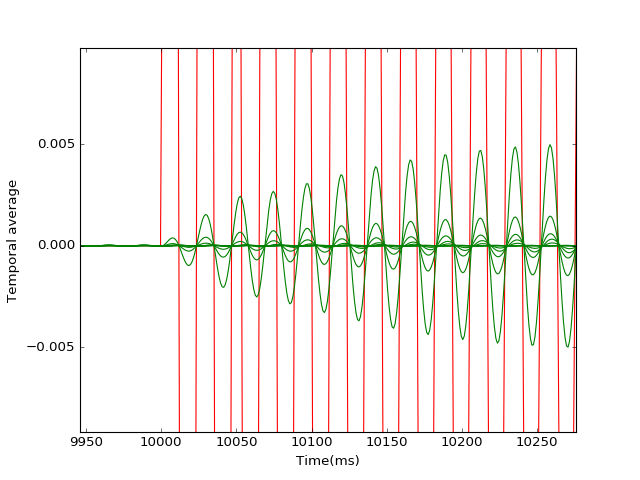

In [59]:
#time vs temporal average graph
figure()
plot(tavg_time, d, 'r', alpha = 1)
plot(tavg_time, follow, 'g', alpha =1)
ylabel("Temporal average")
xlabel ("Time(ms)")
plt.grid('off')

### Finding a threshold

In [26]:
time_notrans = tavg_time[range(9800,12000)]
data_notrans_mean= tavg_data.squeeze().T[:,range(9800, 10000)]
data_notrans= tavg_data.squeeze().T[:,range(9800, 12000)]

data_notrans_posthr= []
data_notrans_negthr= []
data_notrans_thr= []

for node in range(len(data_notrans_mean)):
    data_notrans_posthr.append(np.array(data_notrans[node]>(data_notrans_mean[node].max())))
    data_notrans_negthr.append(np.array(data_notrans[node]<(data_notrans_mean[node].min())))
    data_notrans_thr.append(np.array(data_notrans_posthr[node] + data_notrans_negthr[node]))

### Finding activation times

In [27]:
activation_time=np.array(np.zeros(len(data_notrans_thr)))
for node in range(len(data_notrans_thr)):
    for time in range(9800,12000):
        if np.array(data_notrans_thr[node][time -9800]) == True:
            activation_time[node]=time
            break
        else:
            activation_time[node]= nan
#activation_time

In [28]:
s = [stim_node,36,69,72,22,13,14,40,66,8,19, 18,3,56,49,1,2]
activation_time_spec=np.array(np.zeros(len(s)))
i= 0
for node in s: 
    for time in range(9800,12000):
        if np.array(data_notrans_thr[node][time -9800]) == True:
            activation_time_spec[i]=time
            break
        else:
            activation_time_spec[i]= nan
    i += 1
activation_time_spec

array([ 10000.,  10551.,  10226.,  10597.,  11343.,  10001.,  10001.,
        10031.,  10004.,  11227.,  10168.,  10306.,  10123.,  10004.,
        10054.,  10007.,  10006.])

In [ ]:
activation_times_spec=np.zeros(len(activation_time_spec))
for i in range(len(activation_time_spec)):
    if activation_time_spec[i] == 0 or activation_time_spec[i] < 10000:
        activation_times_spec[i]= nan
    else:
        activation_times_spec[i]= activation_time_spec[i] - 10000

Save the activation times externally for future use. 

In [ ]:
cd /tmp/

In [ ]:
file_name= stim_name + '_data.txt'
np.savetxt(file_name, activation_times_spec)

### Loading in region labels

In [ ]:
import pandas as pd
pd.set_option('display.max_rows',200)
df_tavg = pd.DataFrame(np.squeeze(tavg_data),index=tavg_time)
labs= pd.read_csv('/home/htian/Data/kelly_matrix/labelnames.txt',sep='\t')['acronym'].values
lh_labs = [l + '_L' for l in labs]
rh_labs = [l + '_R' for l in labs]
region_labels_lr = np.concatenate([lh_labs, rh_labs])
df_tavg_labs = df_tavg.copy()
df_tavg_labs.columns= region_labels_lr

### Bar graphs

In [ ]:
lab_spec= np.array(['stim' ,'FEF', 'V2', 'V4', '7a', '35', '36', 'Ig', 'TF', '24/ACC', '46', 
                    '45', '12', 'Pro', 'PAC', '10', '11'])

In [ ]:
df_activation_spec= pd.DataFrame(activation_times_spec, lab_spec) 
lst_nodes = [i for i in range(154) if i != stim_node]
labels_nostim=region_labels_lr[lst_nodes]

In [ ]:
df_activation_spec_sort = df_activation_spec.sort(columns= 0)

In [ ]:
df_activation_spec_sort = df_activation_spec.sort(columns =0)
ax = df_activation_spec_sort.plot(kind='barh', title="distances", figsize=(9,6), legend=False)
y_pos = np.arange(len(df_activation_spec_sort))
width= 0.05
rects = ax.barh(y_pos, df_activation_spec_sort, width)

ax.set_ylabel('node acronyms')
ax.set_xlabel('time activation(ms)')
ax.invert_yaxis()
ax.set_title('Node Activation Times')
ax.set_xlim(0,1600)

### distances from stim

In [ ]:
i =stim_node 
distances= np.array(np.zeros(len(new_conn.tract_lengths)))

for j in range(len(new_conn.tract_lengths)): 
    distances[j]= new_conn.tract_lengths[i, j]

In [ ]:
df_distances= pd.DataFrame([labs, distances[:77]]).T
df_distances_labs= df_distances.sort(columns= 1, ascending= True) 

In [ ]:
ax = df_distances_labs.plot(kind='barh', title="distances", figsize=(10,10), legend=False)
y_pos = np.arange(len(distances[:77])) 
width= 0. 
rects = ax.barh(y_pos,df_distances_labs[1], width) 
ax.set_ylabel('node acronyms') 
ax.set_xlabel('Distances')
ax.set_title('Distance from stim node') 
ax.invert_yaxis()
ax.set_yticks(range(len(labs))) 
ytickNames = ax.set_yticklabels(df_distances_labs[0])

### Finding amplitudes of each node

In [ ]:
import pandas as pd

In [ ]:
#no stim node in this data set 
data_nostim= nostimnode.T

max_amp= [] 
for node in range(len(data_nostim)): 
    max_amp.append(max(abs(data_nostim[node, range(9800,10000)])))

df_max_amp= pd.DataFrame(max_amp, labels_nostim) 
df_max_amp_sort= df_max_amp.sort(columns=0) 

In [ ]:
ax = df_max_amp_sort.plot(kind='barh', title="amplitudes", figsize=(10,10), legend=False) 
y_pos = np.arange(len(df_max_amp_sort)) 
width= 0. 
rects = ax.barh(y_pos, df_max_amp_sort, width)
ax.set_ylabel('node acronyms') 
ax.set_xlabel('amplitude') 
ax.invert_yaxis() 
ax.set_title('Amplitudes')

### Heat map

In [ ]:
import seaborn as sns 
fig, ax = plt.subplots(figsize = (10, 10)) 
sns.heatmap(df_tavg_labs.ix[9800:12000].T, ax=ax, vmin=-0.001, vmax=0.001, xticklabels='') 
ax.imshow(df_tavg.ix[9800:12000].T.values,vmin=-0.001, vmax=0.001, 
          aspect='auto',cmap='coolwarm', interpolation='none') 
ax.set_yticklabels 
ax.grid('off') 
for label in ax.get_yticklabels(): 
    label.set_rotation(0)

### Covariance Matrix

In [ ]:
dat_raw= (nostimnode).T 
dat_notrans_prestim= np.squeeze(dat_raw)[:,range(9800, 10000)] 
dat_notrans_prestim.shape

lst_nodes = [i for i in range(154) if i != stim_node] 
labels_nostim=region_labels_lr[lst_nodes]

In [ ]:
fig, ax= plt.subplots(figsize= (9,9)) 
fig.canvas.draw() 
ax.set_xticks(range(len(labels_nostim))) 
ax.set_yticks(range(len(labels_nostim))) 
ax.set_xticklabels(labels_nostim,rotation=90,fontsize=8) 
ax.set_yticklabels(labels_nostim, fontsize=8) 
plt.imshow(np.cov(dat_notrans_prestim), cmap= 'jet') 
plt.grid('off') 
plt.colorbar()

### Eigen vector matrix

In [ ]:
from scipy.linalg import eig

dat_notrans_cov = np.cov(dat_notrans_prestim) 
dat_notrans_cov_evals, dat_notrans_cov_evecs = np.linalg.eig(dat_notrans_cov)
fig, ax =plt.subplots(figsize= (9,9)) 
fig.canvas.draw() 
ax.set_xticks(range(len(labels_nostim))) 
ax.set_yticks(range(len(labels_nostim))) 
ax.set_xticklabels(labels_nostim,rotation=90,fontsize=8) 
ax.set_yticklabels(labels_nostim, fontsize= 8)

#changed all 154 to 155 to take 0 into account 
dat_notrans_cov_evecs_155 = np.zeros([155,155]) 
dat_notrans_cov_evecs_155[:153,:153] = dat_notrans_cov_evecs 
plt.imshow(dat_notrans_cov_evecs_155, cmap= 'jet') 
plt.grid('off') 
plt.colorbar()

### Time slice on brain using surface plotting

### Make fig

In [ ]:
ctx_file= '/home/htian/Data/newzip.zip'
rm= np.loadtxt('/home/htian/Data/region_mapping.txt')
hemi= np.loadtxt('/home/htian/Data/fv91_srfData_20170215/hemispheres.txt')
ctx = cortex.Cortex.from_file(source_file = ctx_file)
vtx,tri = ctx.vertices,ctx.triangles

notstim= np.squeeze(tavg_data).copy()
notstim[:, stim_node]= 0
           
m = np.array([(np.abs(notstim[i])).max() for i in range(len(notstim))])
for i in range(len(notstim)):
    for j in range(len(notstim[1])):
        notstim[i,j] /= m[i]

df_notstim = pd.DataFrame(notstim,index=tavg_time)

In [ ]:
cd '/tmp'

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=10)
cmap = cm.Reds
cmap.set_under(color='w')

kws = {'edgecolors': 'k', 'vmin': 0, 'cmap': cmap, 
       'vmax': 1, 'alpha': None, 'linewidth': 0.01}


#ts=[10000.5, 10050.5, 10100.5, 10150.5, 10200.5, 10250.5, 10300.5, 100.5, 10400.5, 10450.5]
ts=[10000.5, 10175.5, 10350.5, 10525.5, 10700.5, 10875.5, 11050.5, 11225.5, 11400.5, 11575.5]

for t_it,t in enumerate(ts):
    data = np.append(df_notstim.ix[t].abs().values, nan)
 
    plot_surface_mpl_mv(vtx=vtx ,tri= tri,rm=rm,data=data, figsize=(10,10),
                    hemi=hemi ,shade_kwargs=kws) 
    
    f = '/tmp/braintmp_' + stim_name +'_t%1.1fms.png' %t
    plt.savefig(f,bbox_inches='tight')
    plt.close()
    plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=10, figsize= (12,60))
for t_it,t in enumerate(ts):
    f =  '/tmp/braintmp_' + stim_name + '_t%1.1fms.png' %t
    ax[t_it].imshow(plt.imread(f))
    ax[t_it].axis('off')
    ax[t_it].set_title('t=%1.1fms' %t,fontsize=9)


In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=10)
cmap = cm.Reds
cmap.set_under(color='w')

kws = {'edgecolors': 'k', 'vmin': 0, 'cmap': cmap, 
       'vmax': 0.01, 'alpha': None, 'linewidth': 0.01}


#ts=[10000.5, 10050.5, 10100.5, 10150.5, 10200.5, 10250.5, 10300.5, 100.5, 10400.5, 10450.5]
ts=[10000.5, 10175.5, 10350.5, 10525.5, 10700.5, 10875.5, 11050.5, 11225.5, 11400.5, 11575.5]

for t_it,t in enumerate(ts):
    data = np.append(df_notstim.ix[t].abs().values, nan)
 
    plot_surface_mpl_mv(vtx=vtx ,tri= tri,rm=rm,data=data, figsize=(10,10),
                    hemi=hemi ,shade_kwargs=kws) 
    
    f = '/tmp/braintmp_' + stim_name +'_t%1.1fms.png' %t
    plt.savefig(f,bbox_inches='tight')
    plt.close()
    plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=10, figsize= (12,60))
for t_it,t in enumerate(ts):
    f =  '/tmp/braintmp_' + stim_name + '_t%1.1fms.png' %t
    ax[t_it].imshow(plt.imread(f))
    ax[t_it].axis('off')
    ax[t_it].set_title('t=%1.1fms' %t,fontsize=9)


### Plotting eigenvector on brain

In [ ]:
#display the data
kws = {'edgecolors': 'k', 'vmin': -1, 'cmap': 'coolwarm', 'vmax': 1, 'alpha': None, 'linewidth': 0.01}
fig, ax = plt.subplots(ncols=4,nrows=2,figsize=(12,6))
for e_it in range(4): 
    dat = dat_notrans_cov_evecs_155[:,e_it]
    
    plot_surface_mpl(vtx=vtx,tri=tri,data=dat,rm=rm,ax=ax[0][e_it],
                 shade_kwargs=kws,view='rh_lat', title='evec %s' %e_it)
    
    plot_surface_mpl(vtx=vtx,tri=tri,data=dat,rm=rm,ax=ax[1][e_it],
                 shade_kwargs=kws,view='superior')

In [ ]:
#display the data with one color

kws = {'edgecolors': 'k', 'vmin': 0, 'cmap': 'Reds', #'vmin': 0.4
       'vmax': 1, 'alpha': None, 'linewidth': 0.01}

fig, ax = plt.subplots(ncols=4,nrows=2,figsize=(12,6))

for e_it in range(4):
    dat = np.abs(dat_notrans_cov_evecs_155[:,e_it])

    plot_surface_mpl(vtx=vtx,tri=tri,data=dat,rm=rm,ax=ax[0][e_it],
                     shade_kwargs=kws,view='rh_lat', title='evec %s' %e_it)

    plot_surface_mpl(vtx=vtx,tri=tri,data=dat,rm=rm,ax=ax[1][e_it],
                     shade_kwargs=kws,view='superior')

---

### all activation times

After running all the stimulations you wanted, load in all your files that you saved previously. Here, we will be saving all the activation times in a dataframe to compare activation times of all stimulations.

In [ ]:
import pandas as pd
act_times= []
act_times.append(np.array(np.loadtxt('S_data.txt')))
act_times.append(np.array(np.loadtxt('CA3_data.txt')))
act_times.append(np.array(np.loadtxt('CA1_data.txt')))
act_times.append(np.array(np.loadtxt('ER_data.txt')))
act_times= np.array(act_times)


In [ ]:
col_labs= ['S','CA3', 'CA1', 'ER']

In [ ]:
df_activation_spec_all = pd.DataFrame(act_times.T,lab_spec, columns= col_labs) 
df_activation_spec_all

Here we visualizing the data with a bar graph.

In [ ]:
ax= df_activation_spec_all.plot(kind='barh', title='Activation times', figsize=(10,10))

ax.set_ylabel('node acronyms')
ax.set_xlabel('time activation(ms)')
ax.invert_yaxis()
ax.set_title('Node Activation Times')
ax.set_xlim(0,2000)